In [1]:
from random import seed
from urllib.request import urlopen

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.image import imsave
from matplotlib.pyplot import imshow

from noddyverse import rand_cmap, get_gz_array

rng = np.random.default_rng(seed=21)


def query_models(model_path, event_query, exact=True):
    """Load the models directory and query it.
    The query is constructed as an SQL-like string.
    """
    ## The below method works but is limited to non-exact "|" queries
    # models = [models[models[k].isin(v)] for k, v in event_query.items()][0]
    s = " & " if exact else " | "
    p = [[f'{k}=="{v}"' for v in event_query[k]] for k in event_query.keys()]
    p = [" | ".join(e) for e in p]
    p = [f"({p1})" for p1 in p]
    q = s.join(p)

    model_df = pd.read_csv(model_path)
    models = model_df.query(q)

    if any(models):
        print(f'Sampling from {len(models)} models matching filter "{event_query}"\n')
    else:
        raise Exception(f'No matches for "{event_query}", check spelling of events')

    return models.reset_index(drop=True)


def sample_models(
    model_df,
    i,
    url="https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2f",
):
    model = model_df.iloc[i]
    tail = f'{model["event03"]}_{model["event04"]}_{model["event05"]}&files='
    f = model["root"].split("/")[2]
    root = f"{url}{tail}{f}"

    d = {"mag": None, "grv": None, "g12": None}
    for key in d.keys():
        skip = 0 if key == "g12" else 8
        d[key] = get_gz_array(f"{root}.{key}.gz", skiprows=skip)

    d["g12"] = d["g12"].reshape((200, 200, 200))
    d["g12"] = np.transpose(d["g12"], (0, 2, 1))

    return d, f, f"{root}.his.gz"


def plot(d, i, f, his, show=True):
    vmin = np.amin(d["g12"])
    vmax = np.amax(d["g12"])
    print(i, f, "STRATIGRAPHY, TILT,", ", ".join(his[72:-41].split("_")))

    cmap = rand_cmap(100, first_color_black=False, verbose=False)
    if show:
        kwargs = {"cmap": cmap, "interpolation": "nearest", "vmin": vmin, "vmax": vmax}
        fig, axes = plt.subplots(1, 5, figsize=(13, 13))
        [ax.axis("off") for ax in axes]
        axes[0].title.set_text("Mag")
        axes[1].title.set_text("Grav")
        axes[2].title.set_text("Map")
        axes[3].title.set_text("W    (N)    E")
        axes[4].title.set_text("N    (W)    S")
        axes[0].imshow(d["mag"], cmap="rainbow")
        axes[1].imshow(d["grv"], cmap="rainbow")
        axes[2].imshow(d["g12"][0, :, :], **kwargs)
        axes[3].imshow(d["g12"][:, 0, :], **kwargs)
        axes[4].imshow(d["g12"][:, :, 0], **kwargs)
        print(f"Download .his file: {his}")
        plt.show()
    else:
        kwargs = {"cmap": cmap, "vmin": vmin, "vmax": vmax}
        imsave(f"grv/model_{his[:-8]}_grv.png", d["mag"], cmap="rainbow")
        imsave(f"mag/model_{his[:-8]}_mag.png", d["grv"], cmap="rainbow")
        imsave(f"map/model_{his[:-8]}_map.png", d["g12"][0, :, :], **kwargs)
        imsave(f"secWE/model_{his[:-8]}_secWE.png", d["g12"][:, 0, :], **kwargs)
        imsave(f"secNS/model_{his[:-8]}_secNS.png", d["g12"][:, :, 0], **kwargs)


In [2]:
num_samples = 10
model_path = "model_list/models.csv"

# Query can be constructed as including, excluding, or specifying any number of
# terms, and each event is handle seperately, using the "exact" variable to
# select a model matching at least one event, or strictly all events.
all = ["FAULT", "SHEAR-ZONE", "FOLD", "TILT", "UNCONFORMITY", "DYKE", "PLUG"]

exact = True
drop = ["FAULT", "SHEAR-ZONE", "FOLD", "TILT", "UNCONFORMITY", "DYKE"]
event03 = [e for e in all if e not in drop]
event04 = ["FOLD", "TILT"]
event05 = ["SHEAR-ZONE"]

event_query = {"event03": event03, "event04": event04, "event05": event05}
model_df = query_models(model_path, event_query, exact=exact)


Sampling from 5782 models matching filter "{'event03': ['PLUG'], 'event04': ['FOLD', 'TILT'], 'event05': ['SHEAR-ZONE']}"



2692 20-09-09-04-36-54-406327543 STRATIGRAPHY, TILT, PLUG, TILT, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_TILT_SHEAR-ZONE&files=20-09-09-04-36-54-406327543.his.gz


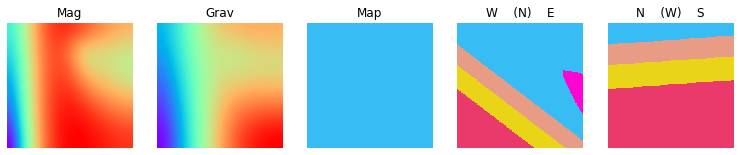

514 20-09-05-12-44-56-344899913 STRATIGRAPHY, TILT, PLUG, TILT, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_TILT_SHEAR-ZONE&files=20-09-05-12-44-56-344899913.his.gz


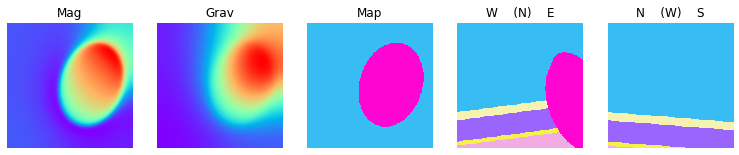

3499 20-09-10-14-06-41-784969514 STRATIGRAPHY, TILT, PLUG, TILT, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_TILT_SHEAR-ZONE&files=20-09-10-14-06-41-784969514.his.gz


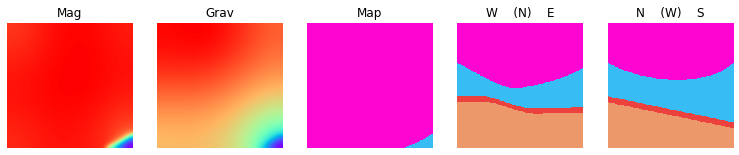

3646 20-09-10-19-41-10-987931928 STRATIGRAPHY, TILT, PLUG, FOLD, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_FOLD_SHEAR-ZONE&files=20-09-10-19-41-10-987931928.his.gz


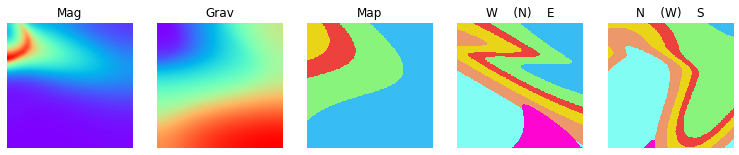

1740 20-09-07-14-11-39-187279030 STRATIGRAPHY, TILT, PLUG, FOLD, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_FOLD_SHEAR-ZONE&files=20-09-07-14-11-39-187279030.his.gz


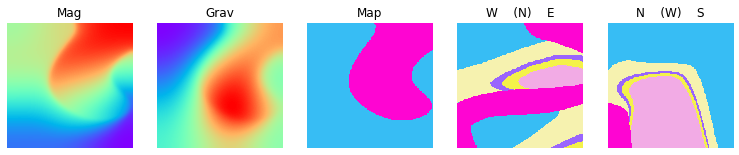

4101 20-09-11-13-11-17-853688670 STRATIGRAPHY, TILT, PLUG, FOLD, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_FOLD_SHEAR-ZONE&files=20-09-11-13-11-17-853688670.his.gz


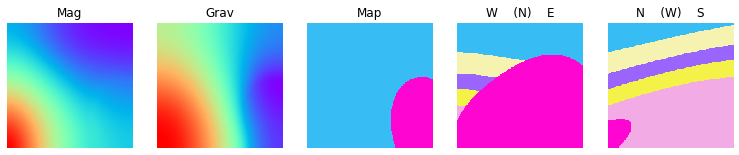

2229 20-09-08-10-51-47-841610992 STRATIGRAPHY, TILT, PLUG, FOLD, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_FOLD_SHEAR-ZONE&files=20-09-08-10-51-47-841610992.his.gz


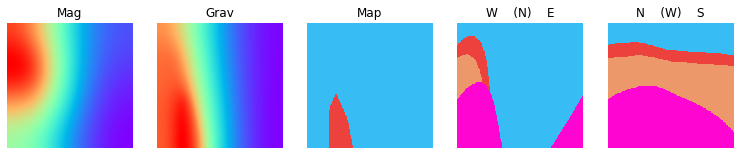

4510 20-09-12-06-06-54-473610748 STRATIGRAPHY, TILT, PLUG, TILT, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_TILT_SHEAR-ZONE&files=20-09-12-06-06-54-473610748.his.gz


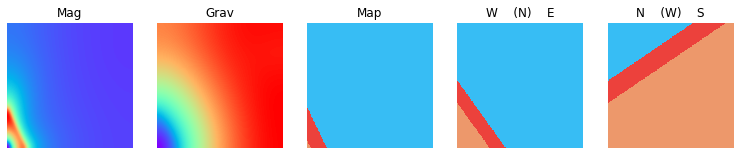

1700 20-09-07-12-24-02-619731158 STRATIGRAPHY, TILT, PLUG, FOLD, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_FOLD_SHEAR-ZONE&files=20-09-07-12-24-02-619731158.his.gz


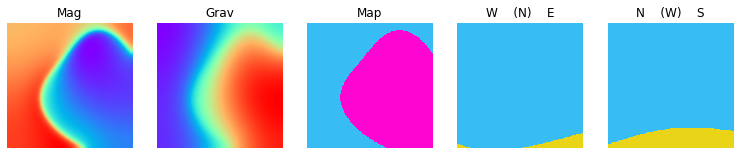

1988 20-09-08-00-10-12-029039954 STRATIGRAPHY, TILT, PLUG, FOLD, SHEAR-ZONE
Download .his file: https://cloudstor.aarnet.edu.au/plus/s/8ZT6tjOvoLWmLPx/download?path=%2fPLUG_FOLD_SHEAR-ZONE&files=20-09-08-00-10-12-029039954.his.gz


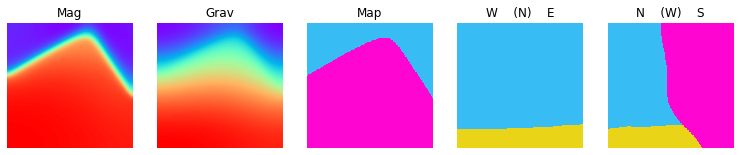

In [3]:
for model_indice in rng.choice(
    np.arange(len(model_df)), size=num_samples, replace=False
):
    #          not sure why we can't use model_df["index"].values
    d, f, his = sample_models(model_df, model_indice)
    plot(d, model_indice, f, his, show=True)
